# Chart individual seat probabilities

## Python set-up

In [1]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from IPython.display import display
import plotting

In [2]:
%load_ext watermark
%watermark --machine --python --iversions --conda

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.1.0

conda environment: n/a

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

matplotlib: 3.10.1
seaborn   : 0.13.2
re        : 2.2.1
IPython   : 9.1.0
numpy     : 2.2.4
pandas    : 2.2.3



In [3]:
## Plotting initialisation
def set_up_plotting() -> None:
    """Set up plotting."""

    p = plotting.get_chart_dir()
    plotting.set_chart_dir(p + "/individual-seats/")
    plotting.clear_chart_dir()


set_up_plotting()

## Get data

In [4]:
FILE = "../betting-data/sportsbet-2025-electorate-betting.csv"
betting_df = pd.read_csv(FILE, na_values="SUS", parse_dates=["timestamp"])
print(f"data length: {len(betting_df)}")
print(f"data start: {betting_df['timestamp'].min()}")
print(f"data end: {betting_df['timestamp'].max()}")
print(f"data columns: {betting_df.columns}")
last = betting_df["timestamp"].max()
print(
    f"Latest seat count: {len(betting_df[betting_df['timestamp'] == last].seat.unique())}"
)
REMOVE_BRACKETS = r"\s*\(.*?\)"
print(
    "Party groups:",
    betting_df.party.str.replace(REMOVE_BRACKETS, "", regex=True).unique(),
)

data length: 5993
data start: 2025-03-30 23:21:13.467650
data end: 2025-04-10 07:01:10.466545
data columns: Index(['Unnamed: 0', 'seat', 'party', 'price', 'timestamp'], dtype='object')
Latest seat count: 150
Party groups: ['Labor' 'Coalition' 'Greens' 'Any Other Candidate' 'Independent'
 'One Nation' "Katter's Australian Party" 'Centre Alliance']


## Plot distribution of simple overrounds

In [5]:
def capture_latest_overrounds(df: pd.DataFrame) -> pd.Series:
    """
    Capture the latest overrounds for each seat in the dataframe.
    The overround is calculated as the sum of the inverse of the prices for each party.
    Arguments:
    df: pd.DataFrame - The dataframe containing the betting data.
    """
    # Filter out rows with missing prices
    df = df.dropna(subset=["price"])

    # Calculate the overround for each seat
    overrounds = {}
    for seat in df.seat.unique():
        overrounds[seat] = (
            df[df.seat == seat]
            .dropna(subset=["price"])
            .pivot(index="timestamp", columns="party", values="price")
            .iloc[-1]
            .pipe(lambda x: 1 / x)
            .sum()
        )
    series = pd.Series(overrounds)

    odd = series[series < 1.05]
    if len(odd):
        print("We have some odd overrounds:")
        for seat in odd.index:
            print(
                seat,
            )
            print(
                df[df.seat == seat]
                .pivot(index="timestamp", columns="party", values="price")
                .iloc[-1]
            )
        print("-" * 30)

    return series

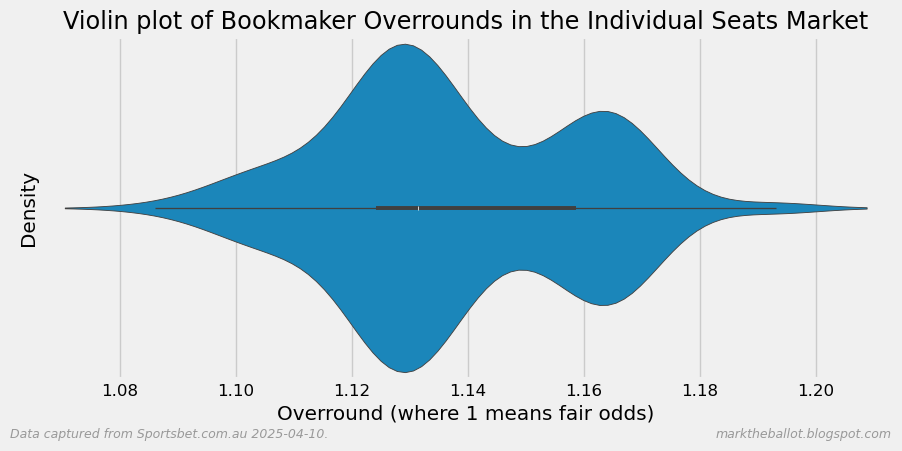

In [6]:
def plot_overrounds() -> None:
    """
    Plot the latest overrounds for each seat in the dataframe.
    """
    overround_series = capture_latest_overrounds(betting_df)
    ax = sns.violinplot(x=overround_series, orient="h")
    title = "Violin plot of Bookmaker Overrounds in the Individual Seats Market"
    plotting.finalise_plot(
        ax,
        title=title,
        ylabel="Density",
        xlabel="Overround (where 1 means fair odds)",
        rfooter="marktheballot.blogspot.com",
        lfooter="Data captured from Sportsbet.com.au "
        + f'{betting_df["timestamp"].max().date()}. ',
        show=True,
    )


plot_overrounds()

## Summarise likely result and identify seats of interest

In [7]:
def calc_probability(df: pd.DataFrame, seat: str) -> tuple[pd.DataFrame, str] | None:
    """
    Calculate the probability of winning for each party in a given seat.
    Arguments:
    df: pd.DataFrame - The dataframe containing the betting data.
    seat: str - The seat to calculate probabilities for.
    Returns a Series with party names as index and probabilities as values.
    """
    # Filter the dataframe for the given seat
    df = df[df.seat == seat]

    # Check if the dataframe is empty
    if df.empty:
        print(f"No data for seat {seat}")
        return None

    # get seat probabilities - treat for favourite-longshot bias
    CAP = 0  # 25  # dollars cap for including odds
    seat_probs = (
        df[df.seat == seat]
        .dropna(subset=["price"])
        .pivot(index="timestamp", columns="party", values="price")
        .sort_index(ascending=True)
        .pipe(lambda x: x * np.sqrt(x))  # Favourite-Longshot Bias management
        .pipe(lambda x: x if not CAP else x[x <= CAP])  # reomove outliers
        .dropna(how="all", axis=1)
        .pipe(lambda x: 1 / x)
        .pipe(lambda x: x.div(other=x.sum(axis=1), axis=0))  # normalise
    ) * 100  # per cent
    method = (
        "Favourite-Longshot Bias treatment: raw-odds * sqrt(raw-odds) "
        + (f" & ${CAP} odds cap" if CAP else "")
    )
    return seat_probs, method

In [8]:
def colourise(s: str, count: int = 0) -> tuple[str, str]:
    """A standard color and marker scheme for parties."""

    settings = {
        "coalition": ("royalblue", "s"),
        "labor": ("#dd0000", "d"),
        "green": ("mediumseagreen", "o"),
        "independent": (
            ["darkorange", "orange", "purple", "teal"][count],
            "v>^<"[count],
        ),
        "one nation": ("darkkhaki", "H"),
        "jacqui lambie": ("darkorchid", "P"),
        "katter": ("hotpink", "X"),
        "centre alliance": ("brown", "P"),
        "other": ("skyblue", "|"),  # must be last
    }
    for party, setting in settings.items():
        if party in s.lower():
            return setting

    return ("gray", "*")


class Coloriser:
    """A class to handle colorisation of party names.
    Note: this is a bit of a hack, but it works for now.
    It allows for multiple independents to be colourised differently."""

    def __init__(self):
        self.x = {}

    def __call__(self, s: str) -> tuple[str, str]:
        core = re.sub(REMOVE_BRACKETS, "", s).strip()
        count = self.x.get(core, -1) + 1
        self.x[core] = count
        return colourise(s, count)


_color = Coloriser()
print(_color("Independent"))
print(_color("Independent"))

('darkorange', 'v')
('orange', '>')


Grouped probabilities for Calare (NSW): Index(['Any Other Candidate', 'Coalition', 'Independent (Andrew Gee)',
       'Independent (Kate Hook)', 'Labor'],
      dtype='object', name='party')
Grouped probabilities for Monash (VIC): Index(['Any Other Candidate', 'Coalition', 'Independent (Deb Leonard)',
       'Independent (Russell Broadbent)', 'Labor'],
      dtype='object', name='party')
Close seats:


,index,Top probability %,ahead
3,Brisbane (QLD),38.4,Labor
16,Macnamara (VIC),48.8,Labor
7,Cowper (NSW),50.5,Coalition
20,Ryan (QLD),50.7,Coalition
17,McEwen (VIC),51.0,Labor
18,Paterson (NSW),52.5,Coalition
21,Wannon (VIC),52.7,Coalition
14,Lingiari (NT),53.2,Labor
13,Kooyong (VIC),53.7,Coalition
2,Bradfield (NSW),55.0,Coalition


Seats where Greens might be competitive:


,Greens win probability %
Melbourne (VIC),93.7
Griffith (QLD),60.5
Macnamara (VIC),37.8
Ryan (QLD),37.6
Wills (VIC),36.9
Brisbane (QLD),30.6
Richmond (NSW),21.1


Seats where Others might be competitive:


,Others win probability %
Clark (TAS),98.5
Kennedy (QLD),95.6
Warringah (NSW),90.6
Wentworth (NSW),89.4
Indi (VIC),88.6
Mayo (SA),87.2
Mackellar (NSW),74.6
Fowler (NSW),73.7
Goldstein (VIC),59.2
Cowper (NSW),48.6


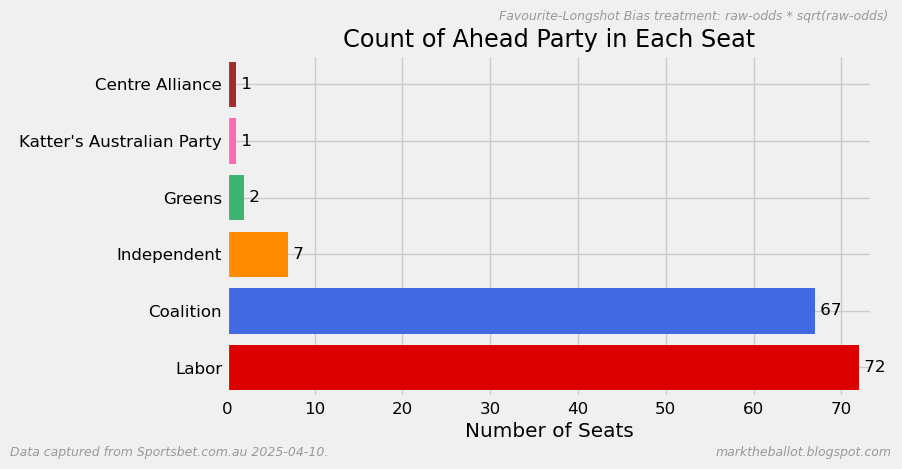

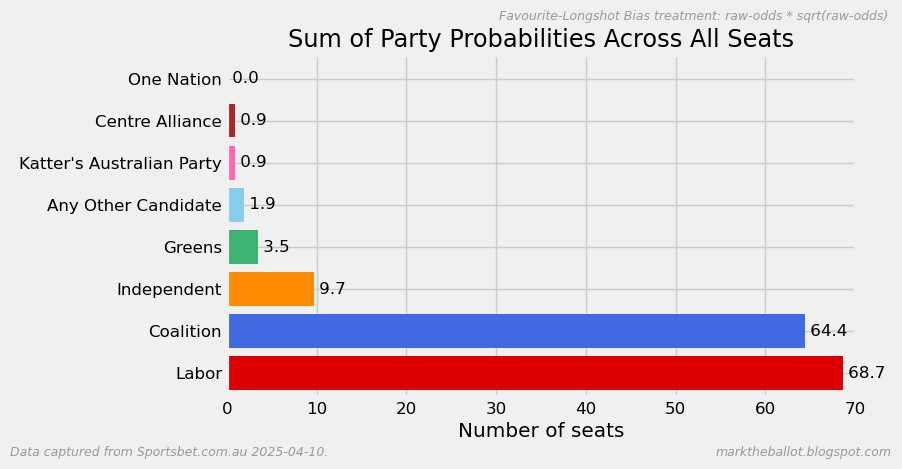

In [9]:
def plot_ahead_count(party_count: dict[str, float], method: str) -> None:
    """Plot the count of the ahead party in each seat."""

    winners = pd.Series(party_count).sort_values(ascending=False)
    assert (
        winners.sum() == 150
    ), f"Count of ahead parties does not sum to 150 {winners.sum()}"
    colors = [colourise(x)[0] for x in winners.index]
    _fig, ax = plt.subplots()
    ax.barh(winners.index, winners, color=colors)
    for i, v in enumerate(winners):
        rounded: str = f"{v:.1f}".rstrip("0").rstrip(".")
        ax.text(v, i, f" {rounded}", color="black", va="center", ha="left")  # type: ignore[arg-type]
    plotting.finalise_plot(
        ax,
        title="Count of Ahead Party in Each Seat",
        ylabel=None,
        xlabel="Number of Seats",
        rfooter="marktheballot.blogspot.com",
        lfooter="Data captured from Sportsbet.com.au "
        + f'{betting_df["timestamp"].max().date()}. ',
        rheader=method,
        show=True,
    )


def plot_party_prob_sum(all_seats_probs: dict[str, pd.Series], method: str) -> None:
    """Plot the party-probability sums."""

    party_probs = pd.DataFrame(all_seats_probs).T.sum().sort_values(ascending=False)
    assert (
        149.9 < party_probs.sum() < 150.1
    ), f"Probabilities do not sum to 150 seats {party_probs.sum()}"
    colors = [colourise(x)[0] for x in party_probs.index]
    _fig, ax = plt.subplots()
    ax.barh(party_probs.index, party_probs, color=colors)
    for i, v in enumerate(party_probs):
        ax.text(v, i, f" {v:0.1f}", color="black", va="center", ha="left")
    plotting.finalise_plot(
        ax,
        title="Sum of Party Probabilities Across All Seats",
        ylabel=None,
        xlabel="Number of seats",
        rfooter="marktheballot.blogspot.com",
        lfooter="Data captured from Sportsbet.com.au "
        + f'{betting_df["timestamp"].max().date()}. ',
        rheader=method,
        show=True,
    )


def tables_of_interest(
    all_seats_probs: dict[str, pd.Series], individual_leaders: dict[str, str]
) -> None:
    """Create tables of interest from the betting data."""

    # tavulate close seats
    seat_probs = pd.DataFrame(all_seats_probs).T * 100
    close_threshold = 70
    close_seats = seat_probs[seat_probs.max(axis=1) <= close_threshold]
    maxima = close_seats.max(axis=1).round(1)
    ahead = pd.Series(individual_leaders)[maxima.index]
    results = pd.DataFrame(
        {
            "Top probability %": maxima,
            "ahead": ahead,
        }
    )
    results = results.reset_index().sort_values(by="Top probability %", ascending=True)
    print("Close seats:")
    display(results)

    # Green possible seats
    green_threshold = 20
    greens = seat_probs["Greens"]
    green_competitive = (
        greens[greens >= green_threshold].sort_values(ascending=False).round(1)
    )
    print("Seats where Greens might be competitive:")
    frame = pd.DataFrame(green_competitive)
    frame.columns = pd.Index(["Greens win probability %"])
    display(frame)

    # Others possible
    other_threshold = 20
    others = seat_probs.drop(columns=["Greens", "Labor", "Coalition"]).sum(axis=1)
    other_competitive = others[others >= other_threshold].sort_values(ascending=False)
    print("Seats where Others might be competitive:")
    display(
        pd.DataFrame(other_competitive, columns=["Others win probability %"]).round(1)
    )


def plot_stacked_probs(all_seats_probs: dict[str, pd.Series], method: str) -> None:
    """Plot the stacked probabilities for each party."""

    # Create a DataFrame from the dictionary
    seat_probs = (pd.DataFrame(all_seats_probs).T * 100).sort_values(
        by="Labor", ascending=False
    )

    first_columns = [f for f in ("Coalition", "One Nation") if f in seat_probs.columns]
    last_columns = [f for f in ("Any Other Candidate", "Greens", "Labor") if f in seat_probs.columns]
    order = (
        first_columns
        + [x for x in seat_probs.columns if x not in first_columns + last_columns]
        + last_columns
    )
    seat_probs = seat_probs[order]
    colours = [colourise(x)[0] for x in seat_probs.columns]

    slices = [slice(0, 150), slice(0, 50), slice(50, 100), slice(100, 150)]
    for i, s in enumerate(slices):
        suffix = {0: "", 1: "(C)", 2: "(B)", 3: "(A)"}[i]
        size = {0: (9, 25), 1: (9, 9), 2: (9, 9), 3: (9, 9)}[i]
        lpos = {0: "lower right", 1: "lower right", 2: "lower right", 3: "center left"}[
            i
        ]

        ax = seat_probs.iloc[s].plot.barh(stacked=True, color=colours)  # type: ignore[arg-type]
        ax.axvline(50, color="black", linestyle="-", linewidth=0.75)
        ax.margins(0.002)
        plotting.finalise_plot(
            ax,
            title=f"Stacked Win Probabilities for Each Seat {suffix}".strip(),
            ylabel=None,
            xlabel="Win Probability %",
            rfooter="marktheballot.blogspot.com",
            lfooter="Data captured from Sportsbet.com.au "
            + f'{betting_df["timestamp"].max().date()}. ',
            rheader=method,
            show=False,
            legend={"loc": lpos, "fontsize": "x-small", "framealpha": 1.0},
            figsize=size,
        )


def summarise_seats_data() -> None:
    """Summarise the individual seat betting data."""

    all_seats_probs = {}  # {seat: series_of_probabilities}
    party_ahead_count: dict[str, float] = {}  # {party: count}
    individual_leaders = {}  # {seat: party}
    for seat in betting_df.seat.unique():
        # get latest seat probabilities
        p = calc_probability(betting_df, seat)
        if p is None:
            print(f"No data for seat {seat}")
            continue
        seat_probs, method = p
        latest = seat_probs.iloc[-1].dropna()

        # get and count the party/ies ahead - allow for fractional counts when tied
        maxima = latest.max()
        leaders = latest[latest == maxima].index.tolist()
        for leader in leaders:
            party = re.sub(REMOVE_BRACKETS, "", leader).strip()
            party_ahead_count[party] = party_ahead_count.get(party, 0) + (
                1 / len(leaders)
            )
        individual_leaders[seat] = "=, ".join(leaders)

        # let's group probabilities by party name (ignore candidate names)
        renamer = {x: re.sub(REMOVE_BRACKETS, "", x).strip() for x in latest.index}
        groups = latest.rename(index=renamer)
        groups_combined = groups.groupby(
            groups.index
        ).sum()  # eg. more than one independent candidate
        if len(groups_combined) < len(groups):
            print(f"Grouped probabilities for {seat}: {latest.index}")
        all_seats_probs[seat] = groups_combined / 100  # convert to simplex

    tables_of_interest(all_seats_probs, individual_leaders)

    plot_ahead_count(party_ahead_count, method)

    plot_party_prob_sum(all_seats_probs, method)

    plot_stacked_probs(all_seats_probs, method)


summarise_seats_data()

## Plot individual seats

In [10]:
CHANGES = []


def plot_seat_probs(df: pd.DataFrame, seat: str) -> None:
    """
    Plot the seat probabilities for a given seat.
    Arguments:
    df: pd.DataFrame - The dataframe containing the betting data.
    seat: str - The seat to plot.
    """

    # get seat probabilities - treat for favourite-longshot bias
    p = calc_probability(df, seat)
    if p is None:
        print(f"No data for seat {seat}")
        return
    seat_probs, flb_method = p

    # make the index a daily period index and de-duplicate.
    seat_probs.index = pd.PeriodIndex(seat_probs.index, freq="D")
    seat_probs = seat_probs[~seat_probs.index.duplicated(keep="last")]
    if len(seat_probs) > 2 and (seat_probs.iloc[-1] != seat_probs.iloc[-2]).any():
        CHANGES.append(seat)

    # plot
    ax = None
    color = Coloriser()
    for column in seat_probs.columns:
        c, m = color(column)
        ax = seat_probs[column].plot(
            ax=ax,
            markersize=6,
            lw=2.5,
            color=c,
            marker=m,
        )
        if seat_probs[column].iloc[-1] >= 10:
            ax.text(
                seat_probs.index[-1],
                seat_probs[column].iloc[-1],
                f"  {seat_probs[column].iloc[-1]:.0f}",
                fontsize=9,
                color="#444444",
                ha="left",
                va="center",
            )
    if ax is None:
        print(f"No data for seat {seat}")
        return

    plotting.finalise_plot(
        ax,
        title=f"Sportsbet seat win probabilities over time - {seat}",
        ylabel="Implied Win Probability (%)",
        lfooter=flb_method,
        rfooter="marktheballot.blogspot.com",
        legend={"loc": "best", "ncol": 2, "fontsize": "small"},
        ylim=(-5, 105),
        y50=True,
        pre_tag="yy",
        show=False,
    )


def plot_seat_odds(df: pd.DataFrame, seat: str) -> None:
    """
    Plot the seat odds for a given seat.
    Arguments:
    df: pd.DataFrame - The dataframe containing the betting data.
    seat: str - The seat to plot.
    """

    # get seat odds - without FLB treatment
    df = df[df.seat == seat]
    odds = df.pivot(index="timestamp", columns="party", values="price")
    odds.index = pd.PeriodIndex(odds.index, freq="D")
    odds = odds[~odds.index.duplicated(keep="last")]
    odds = odds.sort_index(ascending=True)

    ax = None
    color = Coloriser()
    for column in odds.columns:
        c, m = color(column)
        ax = odds[column].plot(
            ax=ax,
            markersize=6,
            lw=2.5,
            color=c,
            marker=m,
        )
        value = odds[column].iloc[-1]
        if odds[column].iloc[-1] <= 31:
            rounding = 2 if value >= 1.01 else 3
            ax.text(
                odds.index[-1],
                value,
                f"  ${value:.{rounding}f}",
                fontsize=9,
                color="#444444",
                ha="left",
                va="center",
            )

    if ax is None:
        print(f"No data for seat {seat}")
        return

    use_log_scale = False
    if use_log_scale:
        ax.set_yscale("log")
    minmax = ax.get_ylim()
    minmax = (0.9 if use_log_scale else 0, minmax[1])

    plotting.finalise_plot(
        ax,
        title=f"Sportsbet seat odds over time - {seat}",
        ylabel="$ Odds" + (" on a log scale" if use_log_scale else ""),
        lfooter="Decimal odds from Sportsbet.com.au",
        rfooter="marktheballot.blogspot.com",
        legend={"loc": "best", "ncol": 2, "fontsize": "small"},
        pre_tag="zz",
        ylim=minmax,
        show=False,
    )


def plot_all_seats():
    """Plot the seat probabilities for all seats."""

    for seat in betting_df.seat.unique():
        plot_seat_probs(betting_df, seat)
        plot_seat_odds(betting_df, seat)

    if CHANGES:
        print("Seats with changes from penultimate day:", CHANGES)


plot_all_seats()

## Finished

In [11]:
print("finished")

finished
